In [13]:
import pandas as pd
import numpy as np
from  matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set()
import matplotlib.image as mpimg
import os
import random
%matplotlib inline
import cv2


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model

# Data exploration

In [14]:
img_folder=r'Apple/'

In [16]:
def explore_class(class_name:str, nsamples:int):

    if nsamples%5 == 0:
        nrows = int(nsamples/5)
    else:
        nrows = int(nsamples//5 + 1)

    path = f'Apple/Apple {class_name}/'
    plt.figure(figsize=(20,3.5*nrows))
    plt.suptitle(f"Class: {class_name}, number of samples: {len(os.listdir(path))}")
    for i in range(nsamples):
        file = random.choice(os.listdir(path))
        image_path= os.path.join(path, file)
        img=cv2.imread(image_path)
        image_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        ax=plt.subplot(nrows,5,i+1)
        ax.title.set_text(file)

        plt.imshow(image_rgb)

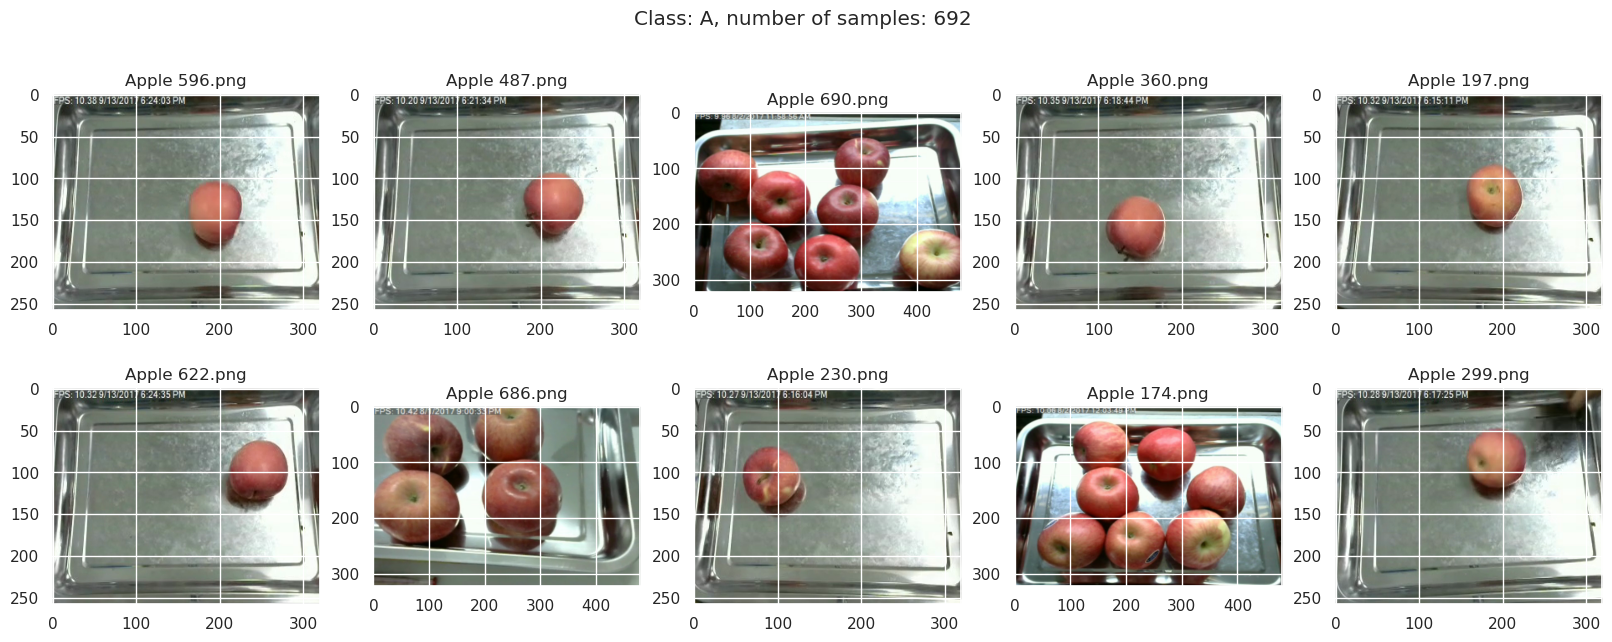

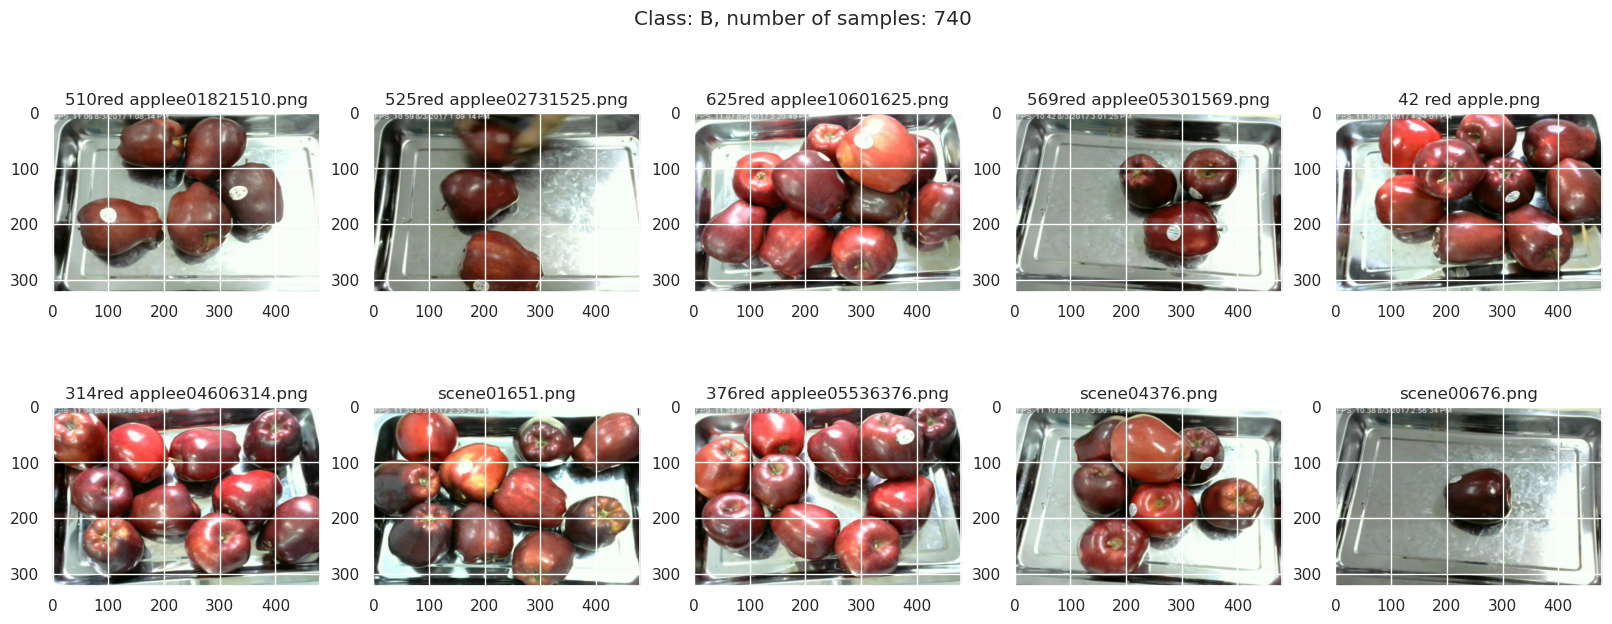

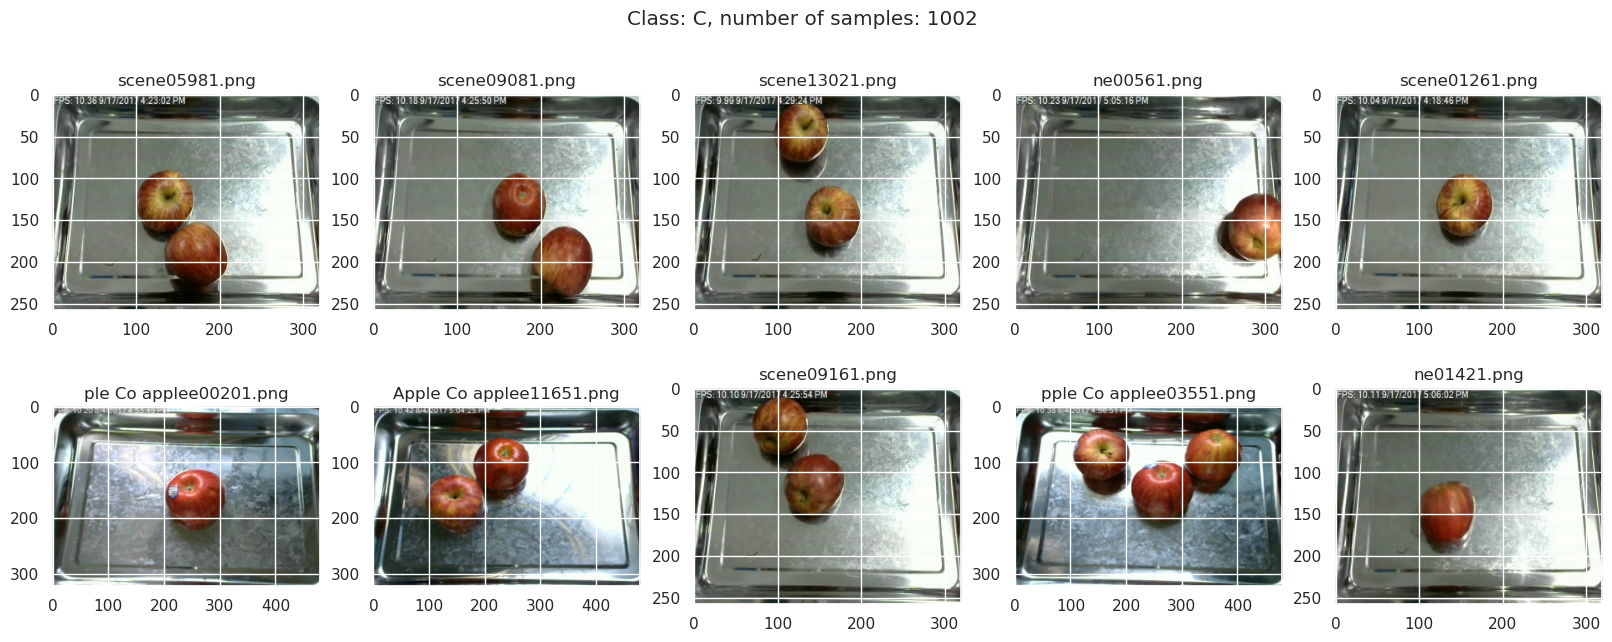

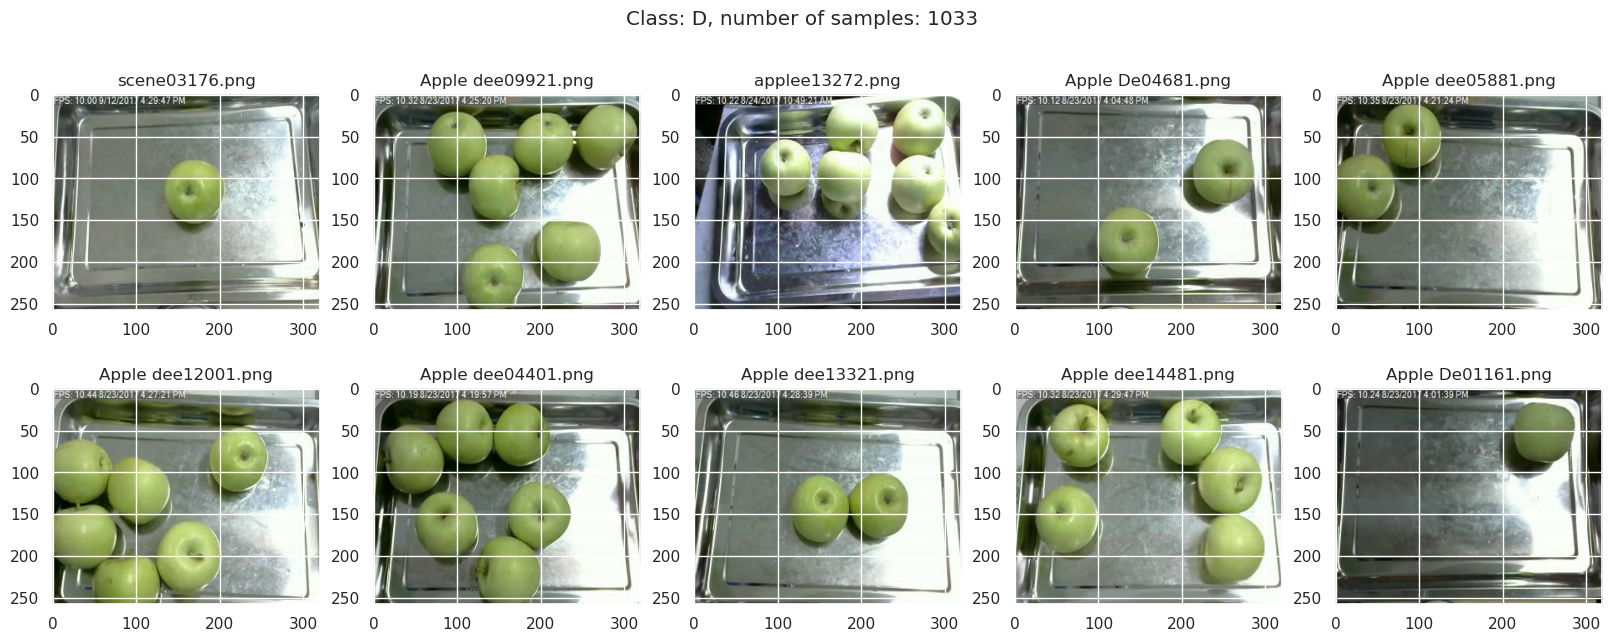

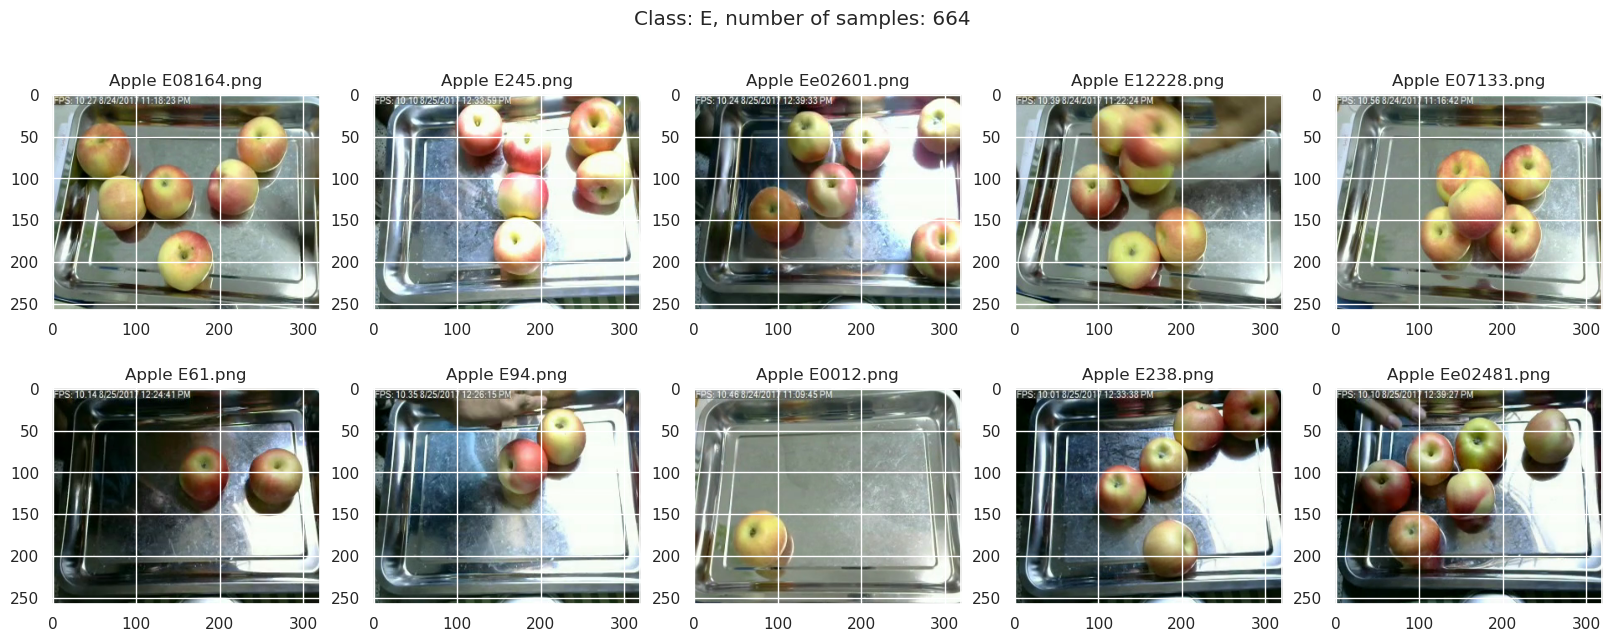

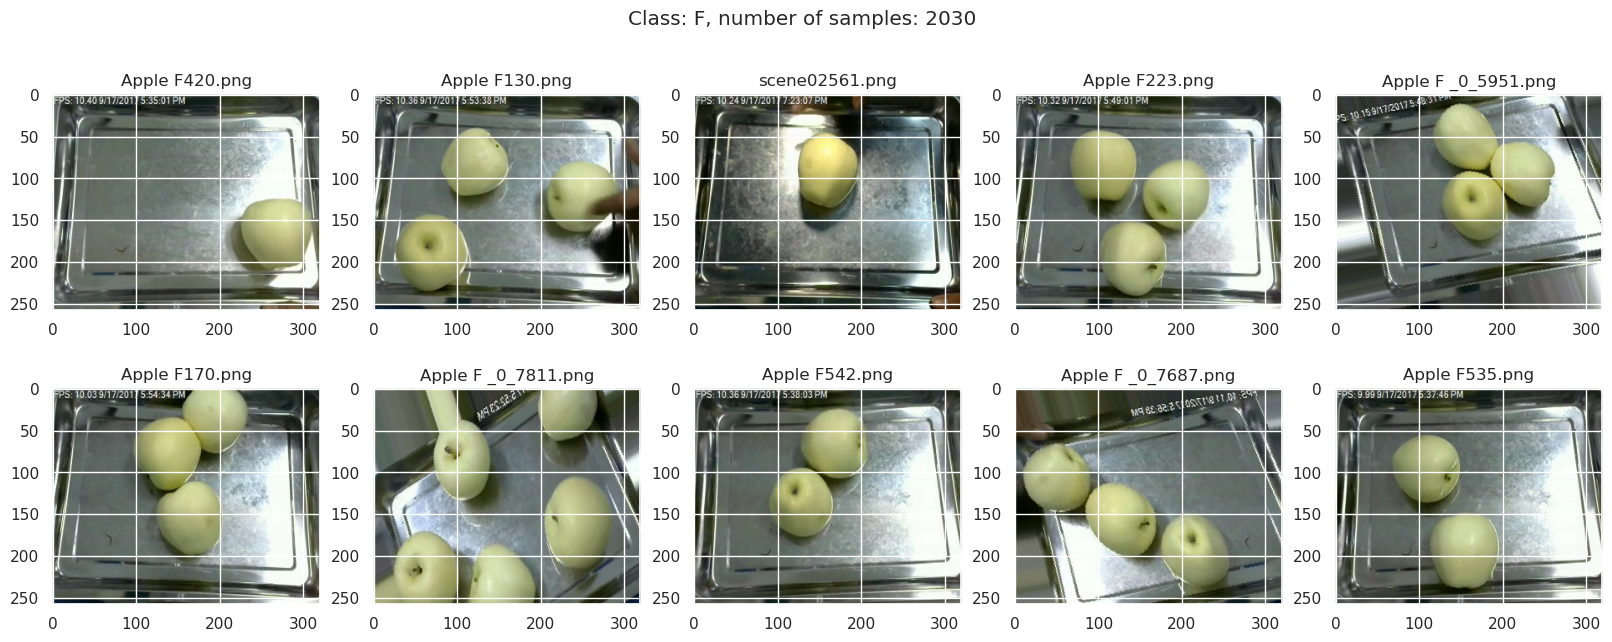

In [17]:
explore_class('A',10)
explore_class('B',10)
explore_class('C',10)
explore_class('D',10)
explore_class('E',10)
explore_class('F',10)

In [18]:
counter = {}

def count_size(img_folder,counter):
   
    for dir in os.listdir(img_folder):
        counter[dir]={}
        for file in os.listdir(os.path.join(img_folder, dir)):
            image_path= os.path.join(img_folder, dir,  file)
            image=cv2.imread(image_path)
            size = image.shape
            if size not in counter[dir]:
                counter[dir][size]=1
            else:
                counter[dir][size]+=1 

In [19]:
count_size(r'Apple',counter)
counter

{'Apple A': {(258, 320, 3): 427, (322, 480, 3): 265},
 'Apple F': {(258, 320, 3): 2030},
 'Apple E': {(258, 320, 3): 664},
 'Apple B': {(322, 480, 3): 740},
 'Apple C': {(258, 320, 3): 666, (322, 480, 3): 336},
 'Apple D': {(258, 320, 3): 1033}}

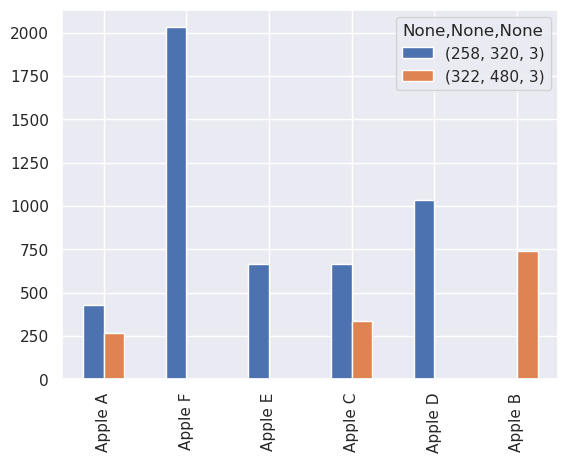

In [20]:
df = pd.DataFrame.from_dict(counter, orient='index')
df.plot(kind='bar')
pass

### Wnioski
* W niektórych klasach występują obrazy o dwóch różnych rozdzielczościach. Więkość stanowią zdjącia o rozmiarze (258x320) pikseli i do tego formatu przekonwertowałaby wszystkie.
* Klasy są niezbalansowane - aby uniknąć problemów przy uczeniu ograniczyłabym liczność każdej z klas do rozmiaru najmniejszej z nich (po ujednoliceniu rozmiaru zdjęć).
* Można równieć (poza klasą B, w której występuja jedyne zdjęcia w rozmiarze 322x480) odrzucić najpierw te o większym rozmiarze i dokonać undersamplingu dla takich danych.
* Klasy E i A oraz F i D są do siebie bardzo zbliżone wyglądem - należałoby rozważyć odrzucenie po jednej z klas w każdej z tych par (klasyfikacja dla 4, a nie 6 różnych klas jabłek).
  

# Data preprocessing

In [21]:
# Docelowy fromat wszystkich zdjęć
IMG_WIDTH=320
IMG_HEIGHT=258

In [22]:
# Testowa funkcja zmieniająca rozmiar wybranych zdjęć - sprawdzenie jak wpływa to na ich jakość:
def reshape_image(class_name:str):
        
        path=f'Apple/Apple {class_name}/'
        file = random.choice(os.listdir(path))
        image_path= os.path.join(path, file)
        imag=cv2.imread(image_path)
        imag = cv2.cvtColor(imag,cv2.COLOR_BGR2RGB)
        imag_reshaped=cv2.resize(imag, (IMG_WIDTH,IMG_HEIGHT),interpolation = cv2.INTER_AREA)
        fig, (ax_0, ax_1) = plt.subplots(nrows=1,ncols=2, figsize=(20,10))
        ax_0.imshow(imag)
        ax_1.imshow(imag_reshaped)
        ax_0.set_title("Original")
        ax_1.set_title("Reshaped") 
        plt.show()

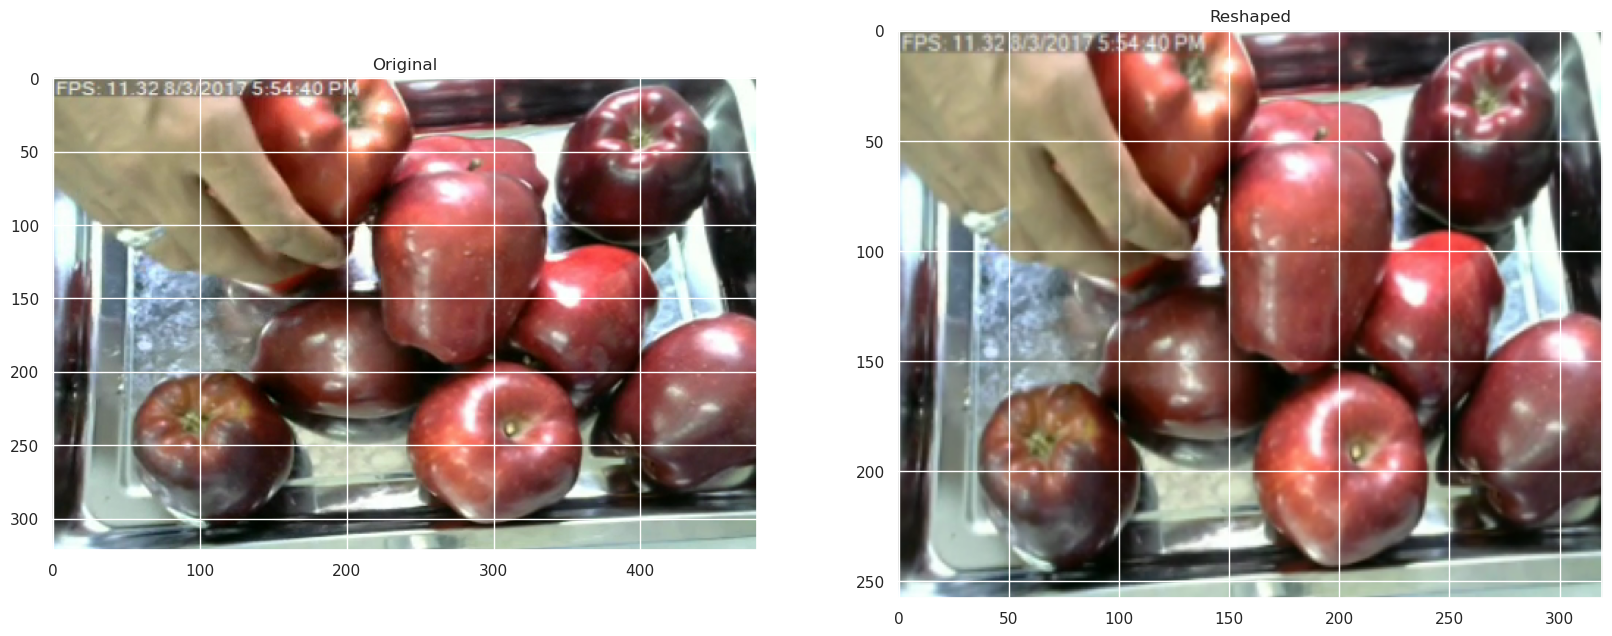

In [25]:
reshape_image('B')

# Tworzenie datasetu

In [28]:

def create_dataset(img_folder):
   
    img_data_array=[]
    class_name=[]
   
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
            image_path= os.path.join(img_folder, dir1,  file)
            image= cv2.imread(image_path)
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
            image=np.array(image)
            image = image.astype('float32')
            # image.reshape(1,-1) #zamiana kształu
            image /= 255 
            img_data_array.append(image)
            class_name.append(dir1)
            
    return img_data_array, class_name 

In [29]:
img_data, class_name = create_dataset(r'Apple')

In [30]:
target_dict={k: v for v, k in enumerate(np.unique(class_name))}
target_dict

{'Apple A': 0,
 'Apple B': 1,
 'Apple C': 2,
 'Apple D': 3,
 'Apple E': 4,
 'Apple F': 5}

In [31]:
target_val=[int(target_dict[class_name[i]]) for i in range(len(class_name))]

# Testowe modele

### Podział na trening i test

In [32]:
# Rozmiar pojedynczego rekordu - zdjęcia
exmp_img = img_data[0]

In [33]:
rows,cols,colors = exmp_img.shape 
img_size = rows*cols*colors
img_1D_vector = exmp_img.reshape(1,-1)
img_1D_vector.shape 

(1, 247680)

In [34]:
type(img_data)

list

In [35]:
X=np.array(img_data, np.float32)
X.shape

(6161, 320, 258, 3)

In [36]:
X_2 = X.reshape(6161,-1)


In [38]:
X_2.shape

(6161, 247680)

In [30]:
X_2[0]

array([[0.43137255, 0.45490196, 0.45490196, ..., 0.5137255 , 0.5254902 ,
        0.5058824 ]], dtype=float32)

In [39]:
y=np.array(target_val, np.float32)
y.shape

(6161,)

In [ ]:
# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X_2, y, stratify=y, test_size=0.3, random_state=42)

In [ ]:
# Wartości y przed treningiem należy poddać tranformacji 'one-hot-encode'
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [9]:
def create_model(neurons:list, optimizer:object, loss:str, dense_activ:str, drop_percent:float, out_activ:str, nclass:int):
    
    """
    Arguments:
        -neurons: list of neurons in each hidden layer, lenght of list is equal to number of hidden layers
        -optimizer: optimizer 
        -loss: loss function
        -dense_activ: dense layer activation funcion
        -drop_percent: percentage of dropped signals in the layer
        -out_activ: out layer activation funcion
        -nclass: number of target classes
    """
    # creates an empty model
    model = tf.keras.Sequential()
    # build model
    # input layer
    model.add(layers.InputLayer(input_shape=(X_train.shape[1])))

    # hidden layers
    for i,neuron_layer in enumerate(neurons):
        model.add(layers.Dense(units=neuron_layer, activation=dense_activ, use_bias=True, name=f"dense-layer-{i+1}"))
        model.add(layers.Dropout(drop_percent,name=f"dropout-layer-{i+1}"))

    # output layer
    model.add(layers.Dense(nclass, activation=out_activ, name="out"))
    
    # summary 
    print(model.summary())

    # compiles model
    model.compile(
        optimizer = optimizer,
        loss = loss,
        metrics=['accuracy']
    )

In [ ]:
base_model = create_model(
                neurons=[64,32], 
                optimizer=optimizers.Adam(learning_rate=0.001), # 0.001  = default learning rate
                loss='categorical_crossentropy', 
                dense_activ='relu', 
                drop_percent=0.3, 
                out_activ='softmax', 
                nclass=3
            )

In [ ]:
results = base_model.fit(
    x=X_train,
    y=y_train,
    batch_size=50,
    epochs=1000,
    verbose=0,
    validation_data=(X_test, y_test)
)

In [ ]:
# Loss function - categorical cross entropy
fig = plt.figure(figsize=(10,5))
plt.plot(results.history["loss"])
plt.plot(results.history["val_loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Categorical cross entropy through training; last value: "+str(round(results.history["loss"][-1],3))+" (train), "+ str(round(results.history["val_loss"][-1],3))+ " (val)")
plt.legend(["train", "validation"])
plt.show()

In [ ]:
# Accuracy
fig = plt.figure(figsize=(10,5))
plt.plot(results.history["accuracy"])
plt.plot(results.history["val_accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy through training; last score: "+str(round(results.history["accuracy"][-1],3))+" (train), "+ str(round(results.history["val_accuracy"][-1],3))+ " (val)")
plt.legend(["train", "validation"])
plt.show()

In [ ]:
def evaluate_model(X,y,model):
        
    y_pred = model.predict(X,verbose=0)
    print(classification_report(y.argmax(axis=1), y_pred.argmax(axis=1)))   
    mat = confusion_matrix(y.argmax(axis=1), y_pred.argmax(axis=1))
 
    sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=target_dict.keys(),
            yticklabels=target_dict.keys())
 
    plt.xlabel('Predicted label')
    plt.ylabel('Actual label')
    pass

In [ ]:
evaluate_model(X_test,y_test,base_model)

### Model konwolucyjny

In [24]:
model=tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)),
            tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(6)
        ])
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [25]:
history = model.fit(x=X_train, y=y_train, epochs=5, verbose=0)

: 

: 